# 1 - Introduction

Name : Gilang Wiradhyaksa

Data : [Faces Dataset](https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset/data)

# 2 - Import Libraries

In [1]:
# Import libraries

import os
import glob
import shutil
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import seaborn as sns
import tensorflow as tf
from pathlib import Path

from jmd_imagescraper.core import *

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [36]:
main_path = 'dataset'

train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'val')

# train_img = glob.glob(train_dir + '/*.jpg')
train_files = glob.glob(train_dir + '/**/*.png', recursive=True)
test_files = glob.glob(test_dir + '/**/*.png', recursive=True)
val_files = glob.glob(val_dir + '/**/*.png', recursive=True)

train_files.sort()
test_files.sort()
val_files.sort()

# 4 - Exploratory Data Analysis

## 4.1 - Data Distribution

In [37]:
counts = [len(train_files), len(test_files), len(val_files)]
labels = ['Train Image', 'Test Image', 'Val Image']

In [2]:
# Image dimensions
img_width, img_height = 120, 120
input_shape = (img_width, img_height, 3) # RGB images

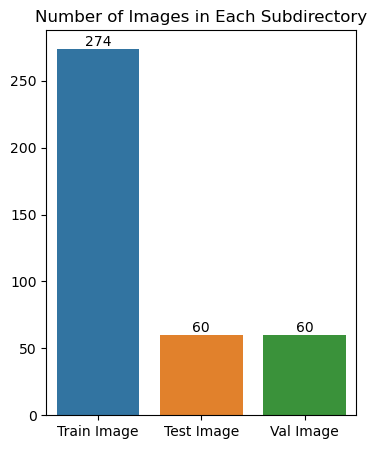

In [38]:
plt.subplots(figsize=(4, 5))
ax = sns.barplot(x=labels, y=counts, orient='v')
ax.bar_label(ax.containers[0])
ax.set(title='Number of Images in Each Subdirectory')
plt.show()

## 4.2 - Data Shape

In [39]:
random_index = np.random.randint(0, len(test_files)-1)

train_img = cv2.imread(train_files[random_index])
test_img = cv2.imread(test_files[random_index])
val_img = cv2.imread(val_files[random_index])

print('Image in Train-set shape:', train_img.shape)
print('Image in Test-set Fruit shape:', test_img.shape)
print('Image in Val-set Fruit shape:', val_img.shape)

Image in Train-set shape: (374, 374, 3)
Image in Test-set Fruit shape: (333, 333, 3)
Image in Val-set Fruit shape: (333, 333, 3)


## 4.3 - Visualize Data

In [40]:
def random_sample(image_files, num_samples=5):
  random_files= random.sample(image_files, num_samples)
  return random_files

In [41]:
random_train = random_sample(train_files)
random_test = random_sample(test_files)
random_val = random_sample(val_files)

In [42]:
def visualize_img(random_data, labels=None):
  fig, axes= plt.subplots(1,5, figsize=(15,12))
  for i, image_path in enumerate(random_data):
    image = plt.imread(image_path)
    axes[i].imshow(image, cmap = 'gray') # bisa tanpa cmap kalau bener2 RGB
    axes[i].set_title(f'{labels}, {image.shape}')
    axes[i].axis('off')
  plt.show()

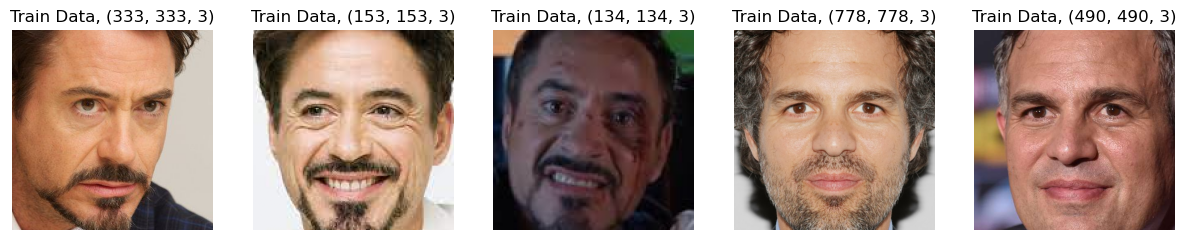

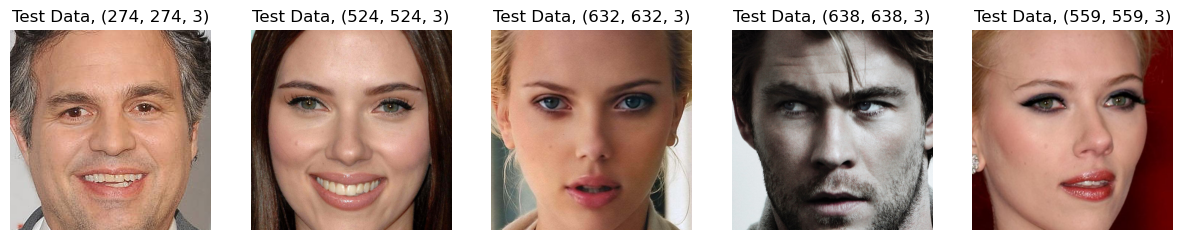

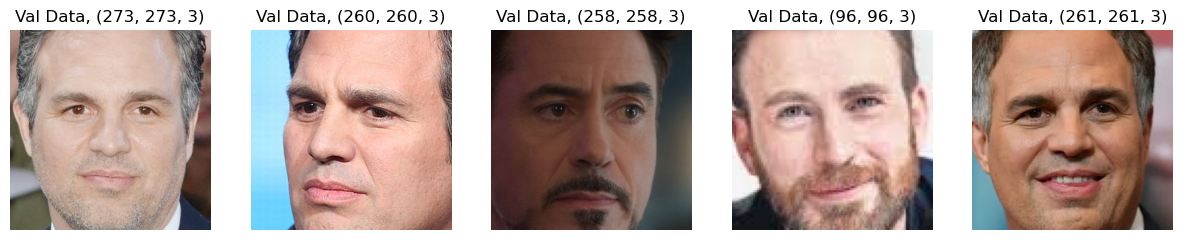

In [43]:
visualize_img(random_train, "Train Data")
visualize_img(random_test, "Test Data")
visualize_img(random_val, "Val Data")

# 5 - Feature Engineering

## 5.1 - Data Generator

In [3]:
# Data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_augmented = ImageDataGenerator(rescale=1./255)
validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

In [4]:
dataset_folder = 'dataset/train'
os.listdir(dataset_folder)

['chris_evans',
 'chris_hemsworth',
 'mark_ruffalo',
 'robert_downey_jr',
 'scarlett_johansson']

In [5]:
# Generate augmented data for training
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'
val_data_dir = 'dataset/val'

train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = 10,
    class_mode = 'categorical',
    classes = os.listdir(train_data_dir),
    subset = 'training'
)

# Generate data for testing
test_generator = test_datagen_augmented.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle = False,
    classes = os.listdir(test_data_dir)
)

# Generate data for validation
validation_generator = validation_datagen_augmented.flow_from_directory(
    val_data_dir,
    target_size = (img_width, img_height),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle = True,
    classes = os.listdir(val_data_dir)
)

Found 274 images belonging to 5 classes.
Found 60 images belonging to 5 classes.
Found 60 images belonging to 5 classes.


In [6]:
class_indices = train_generator.class_indices
print(class_indices)

{'chris_evans': 0, 'chris_hemsworth': 1, 'mark_ruffalo': 2, 'robert_downey_jr': 3, 'scarlett_johansson': 4}


In [7]:
np.random.randint(len(train_generator.next()[0]), size=6)

array([9, 0, 3, 5, 5, 0])

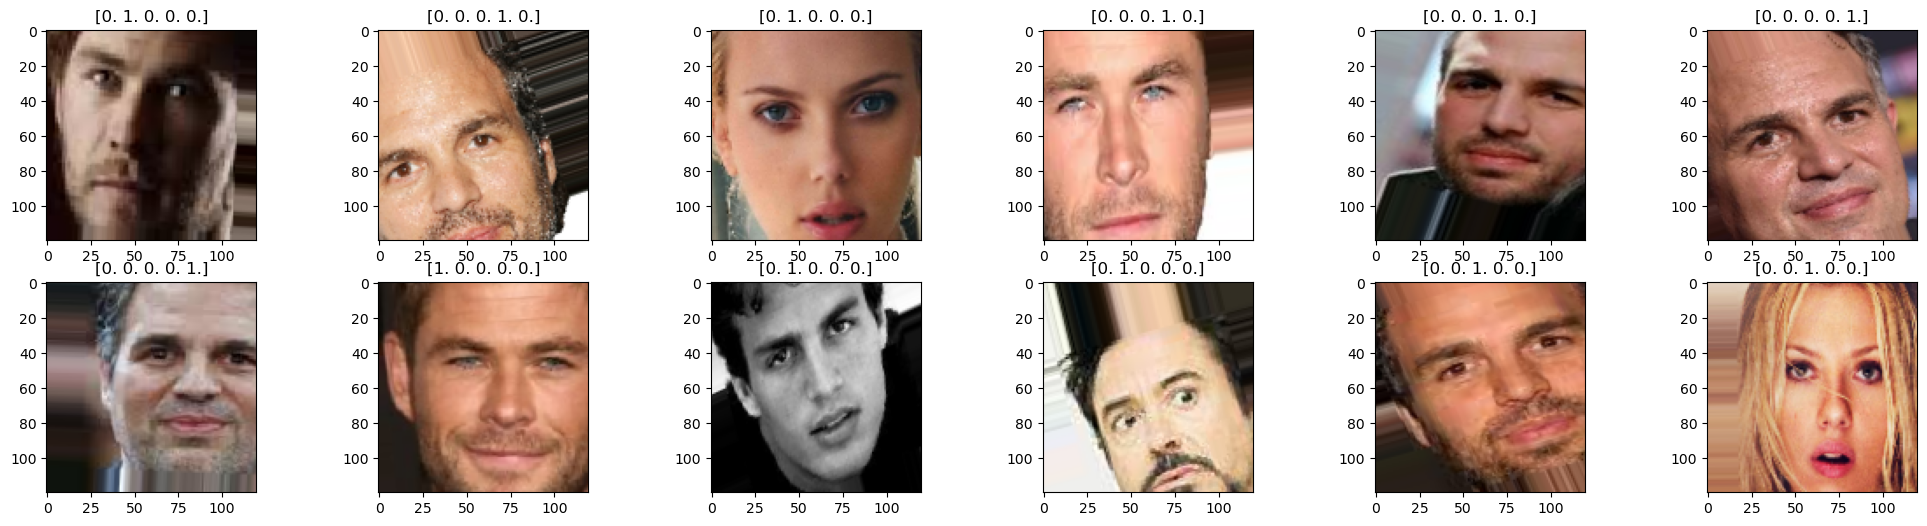

In [8]:
fig,ax = plt.subplots(nrows=2,ncols=6,figsize=(25,6))
n = 0
idx = np.random.randint(len(train_generator.next()[0]), size=12)
for i in range(2):
  for j in range(6):
    img = train_generator.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(train_generator.next()[1][idx[n]])
    n+=1

# 6 - Model Definition & Training

In [24]:
checkpoint_filepath_pooling = 'best_model_pooling.h5'
checkpoint_callback_pooling = ModelCheckpoint(
    filepath=checkpoint_filepath_pooling,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [25]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) ## Global Average Pooling 2D
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [28]:
history = model.fit(train_generator, 
                    epochs=300, 
                    steps_per_epoch=20, 
                    validation_data=validation_generator, 
                    verbose=1, 
                    validation_steps=5, 
                    callbacks=[checkpoint_callback_pooling])

Epoch 1/300
20/20 [==============================] - ETA: 0s - loss: 1.6248 - accuracy: 0.2320
Epoch 1: val_loss improved from inf to 1.62267, saving model to best_model_pooling.h5
20/20 [==============================] - 4s 144ms/step - loss: 1.6248 - accuracy: 0.2320 - val_loss: 1.6227 - val_accuracy: 0.1750
Epoch 2/300
20/20 [==============================] - ETA: 0s - loss: 1.6049 - accuracy: 0.2423
Epoch 2: val_loss improved from 1.62267 to 1.61114, saving model to best_model_pooling.h5
20/20 [==============================] - 3s 146ms/step - loss: 1.6049 - accuracy: 0.2423 - val_loss: 1.6111 - val_accuracy: 0.2500
Epoch 3/300
20/20 [==============================] - ETA: 0s - loss: 1.6111 - accuracy: 0.2600
Epoch 3: val_loss improved from 1.61114 to 1.61070, saving model to best_model_pooling.h5
20/20 [==============================] - 3s 139ms/step - loss: 1.6111 - accuracy: 0.2600 - val_loss: 1.6107 - val_accuracy: 0.2250
Epoch 4/300
20/20 [==============================] - ETA

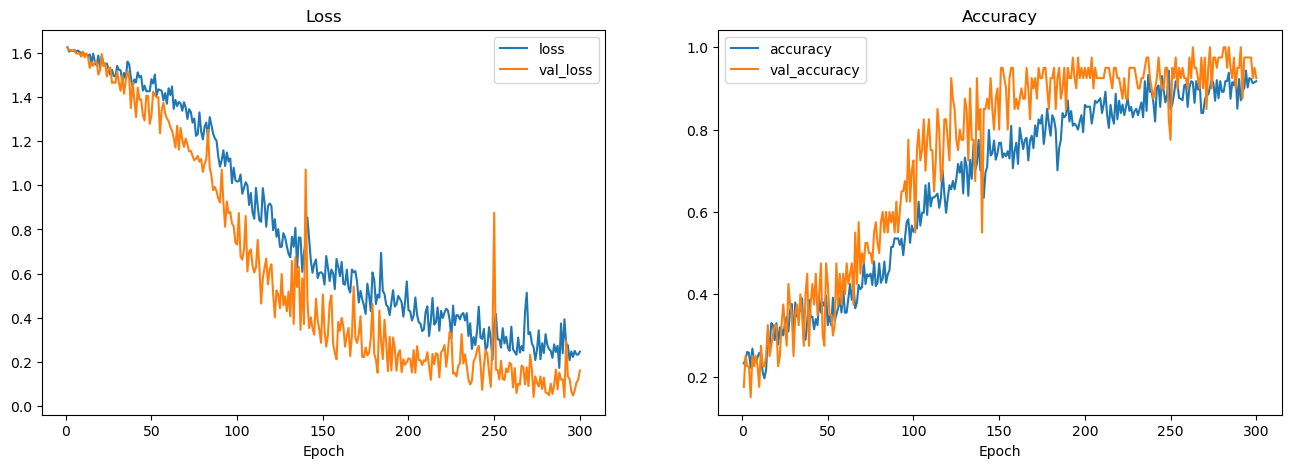

In [29]:
epoch=300

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

## 7 - Model Evaluation

In [30]:
load_model_pooling = load_model("best_model_pooling.h5")

In [31]:
# Predict labels for the test set
predictions = load_model_pooling.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes

8/8 [==============================] - 1s 57ms/step
Predicted Classes: [4 4 4 4 4 4 4 4 3 4]
True Classes: [4 4 4 4 4 4 4 4 4 4]


In [32]:
# print(classification_report(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis = 1)))
print(classification_report(true_classes, predicted_classes, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     1.0000    1.0000    1.0000        12
           2     1.0000    0.9167    0.9565        12
           3     0.8000    1.0000    0.8889        12
           4     1.0000    0.9167    0.9565        12

    accuracy                         0.9500        60
   macro avg     0.9600    0.9500    0.9517        60
weighted avg     0.9600    0.9500    0.9517        60



In [ ]:
# lanjut benerin heading
# lanjut buat ref dan test
# lanjut buat mini program buat jalanin ini semua